In [ ]:
# Check GPU status
!nvidia-smi


Sat Nov  2 12:58:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P400                    Off | 00000000:2D:00.0  On |                  N/A |
| 34%   38C    P8              N/A /  N/A |    244MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
from sklearn.preprocessing import LabelEncoder


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns
from sklearn.manifold import TSNE


# torch geometrics
import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN
import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score
# # Grape

2024-11-02 12:58:49.103964: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 12:58:49.155372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 12:58:49.886854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
# # Grape
# from grape.datasets import get_all_available_graphs_dataframe
# from grape.datasets import get_dataset
from grape import Graph
from grape import GraphVisualizer

# # Ensmallen
# from grape.embedders import Node2VecCBOWEnsmallen, Node2VecGloVeEnsmallen, Node2VecSkipGramEnsmallen
# from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkGloVeEnsmallen, DeepWalkSkipGramEnsmallen
# from grape.embedders import WalkletsSkipGramEnsmallen, WalkletsCBOWEnsmallen, WalkletsGloVeEnsmallen
# from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
# #from grape.embedders import NetMFEnsmallen, GLEEEnsmallen, HOPEEnsmallen
from grape.embedders import TransEEnsmallen

# # TensorFlow
# from grape.embedders import SkipGramTensorFlow, CBOWTensorFlow
# from grape.embedders import FirstOrderLINETensorFlow, SecondOrderLINETensorFlow

# # KarateClub
# from grape.embedders import Role2VecKarateClub, GraRepKarateClub
# from grape.embedders import NMFADMMKarateClub, RandNEKarateClub


# # Edge prediction evaluation
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
# from grape.node_label_prediction import node_label_prediction_evaluation
# from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Load graph
view=5
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/home/mayank/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [7]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [8]:
# IMPORT METHODS

# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [9]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [10]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

# train_data = Data(x=nodes_x,
#                   edge_index=edge_index, edge_type=edge_type,
#                   edge_label_index=edge_index,
#                   edge_label=torch.ones(edge_index.size(1))
#                     )

# train_data = train_data.to(device)

In [11]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

transform = RandomLinkSplit(is_undirected=False)

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
test_data = test_data.to(device)
val_data = val_data.to(device)

In [12]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 1590078  Test:454306  Validation: 227152


In [13]:
# Model

model = ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50, # The hidden embedding size.
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6)

# ALTERNATIVE MODELS

# model_map = {
#     'transe': TransE,
#     'complex': ComplEx,
#     'distmult': DistMult,
#     'rotate': RotatE,
# }

# Proposed configurations
# optimizer_map = {
#     'transe': optim.Adam(model.parameters(), lr=0.01),
#     'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
#     'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
#     'rotate': optim.Adam(model.parameters(), lr=1e-3),
# }

In [14]:
# Training definitions

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

In [ ]:
# Training
n_epochs=52

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6917
Epoch: 003, Loss: 0.6885
Epoch: 004, Loss: 0.6841
Epoch: 005, Loss: 0.6790
Epoch: 006, Loss: 0.6734
Epoch: 007, Loss: 0.6674
Epoch: 008, Loss: 0.6610
Epoch: 009, Loss: 0.6545
Epoch: 010, Loss: 0.6479
Epoch: 011, Loss: 0.6413
Epoch: 012, Loss: 0.6348
Epoch: 013, Loss: 0.6283
Epoch: 014, Loss: 0.6220
Epoch: 015, Loss: 0.6157
Epoch: 016, Loss: 0.6096
Epoch: 017, Loss: 0.6039
Epoch: 018, Loss: 0.5981
Epoch: 019, Loss: 0.5926
Epoch: 020, Loss: 0.5874
Epoch: 021, Loss: 0.5822
Epoch: 022, Loss: 0.5774
Epoch: 023, Loss: 0.5727
Epoch: 024, Loss: 0.5682
Epoch: 025, Loss: 0.5637


 71%|███████   | 561495/795039 [34:19<14:00, 277.89it/s]

In [ ]:
# Training
n_epochs=75

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.4896
Epoch: 002, Loss: 0.4882
Epoch: 003, Loss: 0.4864
Epoch: 004, Loss: 0.4851
Epoch: 005, Loss: 0.4839
Epoch: 006, Loss: 0.4826
Epoch: 007, Loss: 0.4814
Epoch: 008, Loss: 0.4798
Epoch: 009, Loss: 0.4786
Epoch: 010, Loss: 0.4774
Epoch: 011, Loss: 0.4758
Epoch: 012, Loss: 0.4749
Epoch: 013, Loss: 0.4741
Epoch: 014, Loss: 0.4725
Epoch: 015, Loss: 0.4715
Epoch: 016, Loss: 0.4706
Epoch: 017, Loss: 0.4697
Epoch: 018, Loss: 0.4688
Epoch: 019, Loss: 0.4675
Epoch: 020, Loss: 0.4664
Epoch: 021, Loss: 0.4654
Epoch: 022, Loss: 0.4645
Epoch: 023, Loss: 0.4636
Epoch: 024, Loss: 0.4627
Epoch: 025, Loss: 0.4621


100%|██████████| 806015/806015 [47:57<00:00, 280.08it/s]


Epoch: 025, Val Mean Rank: 5500.65, Val MRR: 0.0350, Val Hits@10: 0.0558
Epoch: 026, Loss: 0.4609
Epoch: 027, Loss: 0.4603
Epoch: 028, Loss: 0.4592
Epoch: 029, Loss: 0.4581
Epoch: 030, Loss: 0.4574
Epoch: 031, Loss: 0.4563
Epoch: 032, Loss: 0.4556
Epoch: 033, Loss: 0.4553
Epoch: 034, Loss: 0.4540
Epoch: 035, Loss: 0.4531
Epoch: 036, Loss: 0.4529
Epoch: 037, Loss: 0.4519
Epoch: 038, Loss: 0.4510
Epoch: 039, Loss: 0.4509
Epoch: 040, Loss: 0.4500
Epoch: 041, Loss: 0.4489
Epoch: 042, Loss: 0.4480
Epoch: 043, Loss: 0.4477
Epoch: 044, Loss: 0.4468
Epoch: 045, Loss: 0.4460
Epoch: 046, Loss: 0.4452
Epoch: 047, Loss: 0.4450
Epoch: 048, Loss: 0.4445
Epoch: 049, Loss: 0.4431
Epoch: 050, Loss: 0.4430


100%|██████████| 806015/806015 [48:12<00:00, 278.68it/s]


Epoch: 050, Val Mean Rank: 5441.67, Val MRR: 0.0350, Val Hits@10: 0.0557
Epoch: 051, Loss: 0.4421
Epoch: 052, Loss: 0.4417
Epoch: 053, Loss: 0.4410
Epoch: 054, Loss: 0.4401
Epoch: 055, Loss: 0.4399
Epoch: 056, Loss: 0.4389
Epoch: 057, Loss: 0.4392
Epoch: 058, Loss: 0.4381
Epoch: 059, Loss: 0.4378
Epoch: 060, Loss: 0.4365
Epoch: 061, Loss: 0.4362
Epoch: 062, Loss: 0.4354
Epoch: 063, Loss: 0.4352
Epoch: 064, Loss: 0.4347
Epoch: 065, Loss: 0.4343
Epoch: 066, Loss: 0.4333
Epoch: 067, Loss: 0.4328
Epoch: 068, Loss: 0.4325
Epoch: 069, Loss: 0.4318
Epoch: 070, Loss: 0.4315
Epoch: 071, Loss: 0.4314
Epoch: 072, Loss: 0.4301
Epoch: 073, Loss: 0.4296
Epoch: 074, Loss: 0.4296


In [23]:
## EXTERNAL TEST SETS

## VIEW 0-2
#test_sets = ['miRNA-disease2bepred']
#test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.txt", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test-.txt",names=["subject","predicate","object"], sep='\t')

In [24]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 125], [True, 31354]]


In [ ]:
rank, mrr, hits_at_10 = test(external_test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 15679/15679 [00:56<00:00, 276.19it/s]

Test Mean Rank: 1810.03, Test MRR: 0.0602, Test Hits@10: 0.1577


In [25]:
node_embedding = pd.DataFrame(model.node_emb.weight.cpu().detach().numpy())

label_encoder = LabelEncoder()
node_types = label_encoder.fit_transform(list(nodes_df.type))
node_embedding.index = nodes_df
len(node_embedding)

85299

In [ ]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
"(<http://www.ncbi.nlm.nih.gov/gene/1163>, Gene)",0.019454,-0.048431,-0.010727,0.047112,-0.036169,0.010635,-0.021835,0.010335,-0.006186,0.025911,...,0.055806,0.029043,0.029542,-0.052032,-0.020035,0.055045,0.004666,0.008001,-0.031917,0.011687
"(<http://purl.obolibrary.org/obo/GO_1902115>, GO)",0.029251,-0.031586,0.024200,-0.011557,0.038311,0.038435,0.062508,0.038829,0.023565,-0.062398,...,0.030214,-0.054478,-0.056289,-0.030296,0.061333,0.031276,-0.021152,-0.022761,0.038475,-0.025494
"(<http://purl.obolibrary.org/obo/MONDO_0009301>, Disease)",0.034207,-0.038086,0.038826,-0.013902,0.043517,0.042458,0.062446,0.042743,0.038228,-0.059685,...,0.033509,-0.049303,-0.051293,-0.033634,0.062199,0.034942,-0.035460,-0.037357,0.046061,-0.040121
"(<http://www.ncbi.nlm.nih.gov/gene/2692>, Gene)",0.032902,-0.051435,-0.022974,0.043112,-0.033500,0.028668,-0.014103,0.028531,-0.000412,0.022251,...,0.059720,0.027756,0.027769,-0.058552,-0.006635,0.055162,-0.001335,0.011799,-0.030872,0.026276
"(<http://purl.obolibrary.org/obo/MONDO_0000535>, Disease)",0.022262,-0.022577,0.030896,-0.021305,0.044498,0.028064,0.050747,0.028110,0.029416,-0.051172,...,0.017766,-0.044712,-0.046255,-0.017652,0.049405,0.018929,-0.027406,-0.029148,0.044854,-0.031969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(<http://purl.obolibrary.org/obo/UBERON_0035110>, Anatomy)",0.039066,-0.039246,0.035505,-0.016457,0.041433,0.048484,0.065912,0.048648,0.036470,-0.062129,...,0.033844,-0.051915,-0.053874,-0.033543,0.066209,0.034661,-0.033930,-0.034923,0.043549,-0.036712
"(<https://www.mirbase.org/mature/MIMAT0002841>, miRNA)",-0.176873,0.195387,-0.115582,-0.208110,0.184800,-0.184767,-0.174969,-0.186635,-0.134675,0.153273,...,-0.200684,0.074408,0.094322,0.195566,-0.180125,-0.192100,0.131971,0.125402,0.121501,0.113437
"(<http://purl.obolibrary.org/obo/CHEBI_36834>, Chemical)",0.032522,-0.035059,0.028838,-0.010044,0.039450,0.042994,0.067330,0.043454,0.029462,-0.066507,...,0.032770,-0.055892,-0.057995,-0.032662,0.066458,0.034327,-0.026616,-0.028195,0.041699,-0.029993
"(<http://purl.obolibrary.org/obo/HP_0500107>, Phenotype)",0.031747,-0.039820,0.044013,-0.015657,0.044618,0.040775,0.061723,0.041101,0.043727,-0.059536,...,0.034072,-0.050332,-0.051963,-0.034572,0.061304,0.034958,-0.041640,-0.042773,0.047595,-0.045160


In [ ]:
!ls -lh


total 8.0K
drwx------ 5 root root 4.0K Aug 19 13:37 drive
drwxr-xr-x 1 root root 4.0K Aug 14 13:23 sample_data


In [ ]:
node_embedding.to_csv('node_embeddings.csv', header=False, index=True, sep=',')

In [8]:
node_embedding = pd.read_csv('/home/mayank/view5_complex_node_embeddings.csv', header = None)

In [9]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,"('<http://www.ncbi.nlm.nih.gov/gene/1163>', 'G...",0.012890,0.061819,0.037308,-0.019249,0.022419,-0.020893,0.035755,-0.059820,0.037500,...,-0.023240,-0.018909,0.030944,-0.022956,-0.041886,6.350719e-37,0.058970,0.005063,-0.058211,-6.348771e-37
1,('<http://purl.obolibrary.org/obo/GO_1902115>'...,0.044673,0.031944,-0.043216,0.029803,-0.064706,0.063520,-0.056725,-0.030300,-0.043142,...,0.031130,0.064782,0.019130,0.064518,0.035378,6.569328e-37,0.032950,-0.028699,-0.032544,6.451884e-37
2,('<http://purl.obolibrary.org/obo/MONDO_000930...,0.045572,0.034615,-0.048229,0.039428,-0.060906,0.061088,-0.047302,-0.030604,-0.048226,...,0.041342,0.061405,0.024231,0.060649,0.040277,4.946420e-37,0.034871,-0.038313,-0.034511,-6.000255e-37
3,"('<http://www.ncbi.nlm.nih.gov/gene/2692>', 'G...",0.015688,0.059819,0.030221,-0.018528,0.014346,-0.013199,0.026170,-0.055970,0.029957,...,-0.021582,-0.012137,0.034666,-0.014549,-0.035508,-6.431812e-37,0.056086,0.007851,-0.055385,-6.658929e-37
4,('<http://purl.obolibrary.org/obo/MONDO_000053...,0.014686,0.008609,-0.047773,0.027265,-0.043101,0.041034,-0.048822,-0.005946,-0.048157,...,0.030497,0.040396,-0.003572,0.043337,0.042588,-5.898185e-37,0.009002,-0.020791,-0.008746,-1.366766e-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85294,('<http://purl.obolibrary.org/obo/MONDO_001271...,0.047540,0.042103,-0.046991,0.047407,-0.065313,0.064484,-0.053042,-0.037421,-0.047299,...,0.048687,0.065592,0.021948,0.064905,0.038105,3.368560e-37,0.041405,-0.048021,-0.041018,-5.822904e-37
85295,('<https://www.mirbase.org/mature/MIMAT0002841...,-0.172683,-0.175699,-0.168164,-0.069570,0.158703,-0.168016,0.054155,0.180093,-0.174539,...,-0.047909,-0.164496,-0.164208,-0.155613,0.184732,6.074247e-37,-0.174887,0.110461,0.174114,6.377019e-37
85296,('<http://purl.obolibrary.org/obo/GO_0102175>'...,0.043632,0.038665,-0.045473,0.034608,-0.060442,0.060034,-0.051390,-0.036881,-0.045055,...,0.035817,0.060927,0.015515,0.060157,0.038727,6.778023e-37,0.040475,-0.034098,-0.040034,6.420482e-37
85297,('<http://purl.obolibrary.org/obo/HP_0500107>'...,0.045701,0.040489,-0.049314,0.052068,-0.064389,0.064416,-0.051817,-0.036952,-0.049578,...,0.052557,0.064513,0.021831,0.064236,0.040187,-5.558157e-37,0.040955,-0.052452,-0.040626,-6.192275e-37


In [10]:
node_embedding.set_index(node_embedding.columns[0], inplace=True)

In [11]:
node_embedding.values

array([[ 1.2890187e-02,  6.1818864e-02,  3.7308183e-02, ...,
         5.0632650e-03, -5.8211220e-02, -6.3487710e-37],
       [ 4.4672683e-02,  3.1944323e-02, -4.3216195e-02, ...,
        -2.8699126e-02, -3.2544024e-02,  6.4518840e-37],
       [ 4.5572240e-02,  3.4615044e-02, -4.8228562e-02, ...,
        -3.8312774e-02, -3.4510950e-02, -6.0002550e-37],
       ...,
       [ 4.3631963e-02,  3.8664546e-02, -4.5472845e-02, ...,
        -3.4098150e-02, -4.0033650e-02,  6.4204820e-37],
       [ 4.5701053e-02,  4.0489264e-02, -4.9313974e-02, ...,
        -5.2452076e-02, -4.0625940e-02, -6.1922750e-37],
       [ 3.9498802e-02,  4.8763826e-02, -3.3915915e-02, ...,
        -5.1149238e-02, -4.8897162e-02,  1.3090370e-38]])

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

In [55]:
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

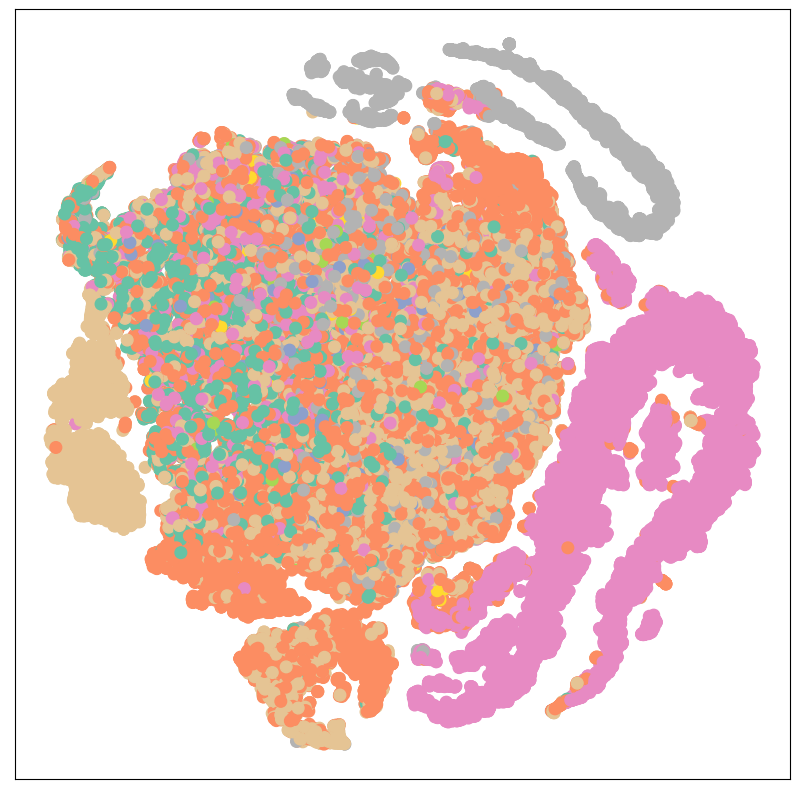

In [56]:
visualize(node_embedding.values,node_types)

In [34]:
node_types

array([10,  9,  5, ...,  9, 19,  5])

/tmp/ipykernel_13843/1780641566.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


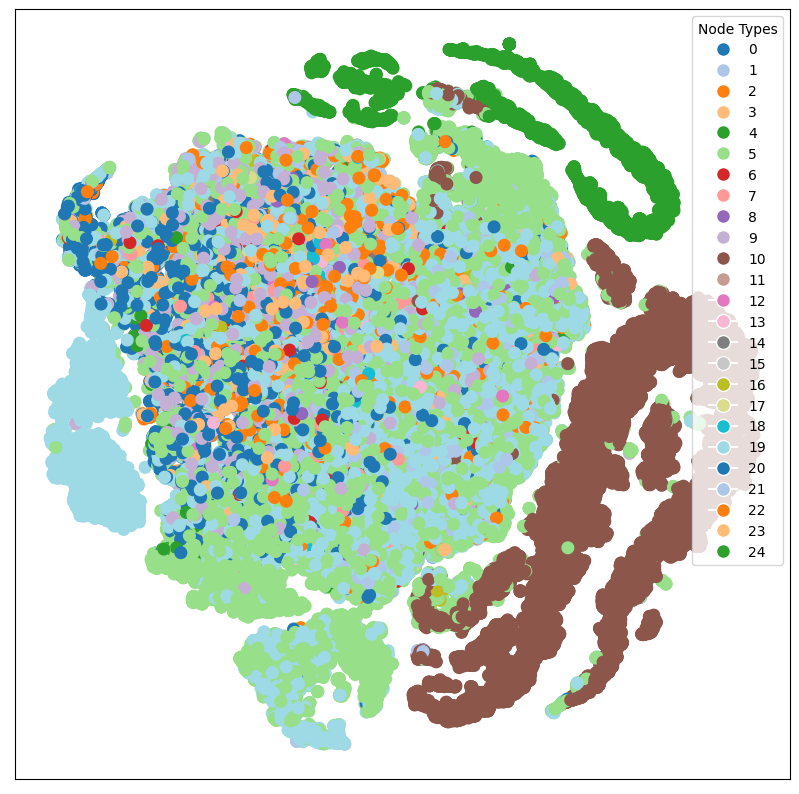

In [44]:
visualize(node_embedding.values,node_types)

In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = node_embedding.values
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6274
Precision: 0.5877
Recall: 0.6274


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

selected_classes = ['miRNA', 'Gene', 'Disease']

filtered_embeddings = []
filtered_labels = []


for class_label in selected_classes:

    class_indices = nodes_df[nodes_df['type'] == class_label].index


    class_embeddings = node_embedding.iloc[class_indices, 1:].values  # Skip the first column with identifiers

    # Append the filtered embeddings and labels
    filtered_embeddings.append(class_embeddings)
    filtered_labels.extend([class_label] * len(class_embeddings))


X_filtered = np.vstack(filtered_embeddings)

# Encode the labels
le = LabelEncoder()
y_filtered = le.fit_transform(filtered_labels)  # Convert the labels into numerical form


X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

precision_per_class = precision_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))
recall_per_class = recall_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))

for i, class_label in enumerate(le.classes_):
    if class_label in selected_classes:
        print(f"Class: {class_label}")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")


Accuracy: 0.9880
Precision: 0.9881
Recall: 0.9880
Class: Disease
  Precision: 0.9868
  Recall: 0.9915
Class: Gene
  Precision: 0.9873
  Recall: 0.9860
Class: miRNA
  Precision: 0.9972
  Recall: 0.9790


In [61]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the labels
true_labels = nodes_df['type']
X =  node_embedding.values

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(true_labels)  # Convert the labels into numerical form

class_distribution = np.bincount(y)
print("Class distribution:", dict(zip(le.classes_, class_distribution)))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42,  class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1-score for each class (node type)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")

for i, class_label in enumerate(le.classes_):
    try:
        precision_class = precision_score(y_test, y_pred, labels=[i], average='macro')
        recall_class = recall_score(y_test, y_pred, labels=[i], average='macro')
        f1_class = f1_score(y_test, y_pred, labels=[i], average='macro')
        print(f"Class: {class_label}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1[i]:.4f}")
    except IndexError:
        print(f"Class: {class_label}")
        print("  Precision: 0.0000 (No predictions for this class)")
        print("  Recall: 0.0000")
        print("  F1 Score: 0.0000")

Class distribution: {'Anatomy': 6129, 'Basic formal': 1, 'Cell': 1272, 'Chemical': 2000, 'Chromosome': 310, 'Disease': 23966, 'Environment': 446, 'Environmental exposure': 419, 'Food': 172, 'GO': 4071, 'Gene': 18341, 'General medical science': 6, 'Human developmental stage': 72, 'Medical action': 114, 'Mental disease': 12, 'Mental functioning': 14, 'Mouse pathology': 75, 'NCI thesaurus': 84, 'Neuro behaviour': 153, 'Phenotype': 18488, 'Protein': 205, 'Sequence': 2386, 'Species': 1766, 'Vaccine': 1, 'miRNA': 4796}


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packag

Overall Accuracy: 0.6265
Class: Anatomy
  Precision: 0.3948
  Recall: 0.4155
  F1 Score: 0.4048
Class: Basic formal
  Precision: 0.2353
  Recall: 0.0104
  F1 Score: 0.0199
Class: Cell
  Precision: 0.1186
  Recall: 0.0234
  F1 Score: 0.0391
Class: Chemical
  Precision: 0.5625
  Recall: 0.2872
  F1 Score: 0.3803
Class: Chromosome
  Precision: 0.5265
  Recall: 0.7268
  F1 Score: 0.6106
Class: Disease
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Environment
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Environmental exposure
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Food
  Precision: 0.3288
  Recall: 0.1956
  F1 Score: 0.2453
Class: GO
  Precision: 0.9847
  Recall: 0.9860
  F1 Score: 0.9853
Class: Gene
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: General medical science
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Human developmental stage
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packag

Class: Medical action
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Mental disease
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Mental functioning
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Mouse pathology
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: NCI thesaurus
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Neuro behaviour
  Precision: 0.5135
  Recall: 0.5171
  F1 Score: 0.5153
Class: Phenotype
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packag

Class: Protein
  Precision: 0.1923
  Recall: 0.0074
  F1 Score: 0.0143
Class: Sequence
  Precision: 0.2000
  Recall: 0.0909
  F1 Score: 0.1250
Class: Species
  Precision: 0.9950
  Recall: 0.9790
  F1 Score: 0.9869
Class: Vaccine
Class: Vaccine
  Precision: 0.0000 (No predictions for this class)
  Recall: 0.0000
  F1 Score: 0.0000
Class: miRNA
Class: miRNA
  Precision: 0.0000 (No predictions for this class)
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [46]:
node_embedding.values

array([[ 1.2890187e-02,  6.1818864e-02,  3.7308183e-02, ...,
         5.0632650e-03, -5.8211220e-02, -6.3487710e-37],
       [ 4.4672683e-02,  3.1944323e-02, -4.3216195e-02, ...,
        -2.8699126e-02, -3.2544024e-02,  6.4518840e-37],
       [ 4.5572240e-02,  3.4615044e-02, -4.8228562e-02, ...,
        -3.8312774e-02, -3.4510950e-02, -6.0002550e-37],
       ...,
       [ 4.3631963e-02,  3.8664546e-02, -4.5472845e-02, ...,
        -3.4098150e-02, -4.0033650e-02,  6.4204820e-37],
       [ 4.5701053e-02,  4.0489264e-02, -4.9313974e-02, ...,
        -5.2452076e-02, -4.0625940e-02, -6.1922750e-37],
       [ 3.9498802e-02,  4.8763826e-02, -3.3915915e-02, ...,
        -5.1149238e-02, -4.8897162e-02,  1.3090370e-38]])

In [13]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)



In [49]:
# Assuming node_embedding index is a tuple of (URI, type)
node_embedding.index = [name[0] for name in node_embedding.index]


In [50]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=node_embedding.values,  # Use simplified embedding features
    smoke_test=False,
    enable_cache=False
)


Evaluating on VIEW5_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

In [89]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_csv(filename)

In [90]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,balanced_accuracy,fall_out,accuracy,precision,negative_likelyhood_ratio,negative_predictive_value,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.491189,0.955302,0.491189,0.495346,1.394233,0.417670,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.492813,0.955484,0.492813,0.496211,1.322884,0.430499,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.496526,0.953636,0.496526,0.498172,1.149856,0.465147,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.497387,0.953679,0.497387,0.498626,1.112811,0.473303,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.497114,0.946880,0.497114,0.498472,1.108648,0.474238,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.496368,0.947520,0.496368,0.498076,1.138411,0.467637,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.495569,0.951564,0.495569,0.497661,1.182981,0.458089,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.497033,0.951676,0.497033,0.498436,1.122802,0.471075,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.495097,0.947900,0.495097,0.497400,1.188217,0.456993,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.496619,0.947969,0.496619,0.498210,1.129960,0.469492,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


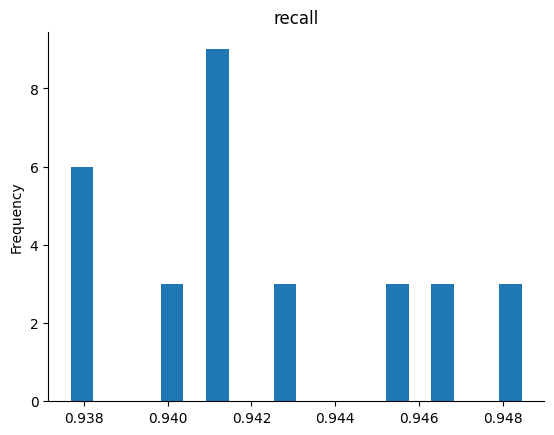

In [91]:
from matplotlib import pyplot as plt
results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

In [15]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[DecisionTreeEdgePrediction()],
    number_of_holdouts=5,
    node_features= node_embedding.values,  # Use simplified embedding features
    smoke_test=False
)

Evaluating on VIEW5_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

In [16]:
results = evaluation
filename = "results_"+view_name+"_FirstOrderLINE_DesicionTree_v5complex.csv"
results.to_csv(filename)


In [17]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,positive_likelyhood_ratio,threat_score,false_discovery_rate,matthews_correlation_coefficient,recall,diagnostic_odds_ratio,...,"(model_parameters, criterion)","(model_parameters, splitter)","(model_parameters, max_depth)","(model_parameters, min_samples_split)","(model_parameters, min_samples_leaf)","(model_parameters, min_weight_fraction_leaf)","(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, ccp_alpha)"
0,train,0.800001,1.0,True,0.977987,0.463484,0.505565,-0.031806,0.881007,0.815006,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.980344,0.464469,0.504963,-0.028452,0.882656,0.832492,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.955219,0.450233,0.511452,-0.059676,0.851651,0.698138,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.951547,0.448650,0.512414,-0.064376,0.848904,0.679324,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.971046,0.469085,0.507345,-0.050148,0.907447,0.687163,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.975740,0.471505,0.506139,-0.042737,0.912403,0.723052,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,1.028622,0.489733,0.492946,0.048437,0.934794,1.438946,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,1.034539,0.492625,0.491512,0.059510,0.940445,1.579950,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.993337,0.207846,0.501671,-0.002001,0.262843,0.990961,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.816615,0.171156,0.550474,-0.056861,0.216541,0.765929,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0


In [18]:
# Separate train and test results
train_results = evaluation[evaluation['evaluation_mode'] == 'train']
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Function to compute mean metrics for a given evaluation mode
def compute_mean_metrics(data):
    results = []
    for holdout in data['holdout_number'].unique():
        holdout_data = data[data['holdout_number'] == holdout]

        # Calculate mean values for metrics
        auc_score = holdout_data['auroc'].mean()
        precision = holdout_data['precision'].mean()
        recall = holdout_data['recall'].mean()
        f1_score = holdout_data['f1_score'].mean()
        accuracy = holdout_data['accuracy'].mean()  # Assuming 'accuracy' column exists

        # Append results for this holdout
        results.append({
            'Holdout': holdout,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Accuracy': accuracy
        })

    # Convert to DataFrame
    return pd.DataFrame(results)

# Compute metrics for train and test
train_metrics_df = compute_mean_metrics(train_results)
test_metrics_df = compute_mean_metrics(test_results)

# Calculate overall mean for train and test
overall_train_mean = train_metrics_df.mean(numeric_only=True)
overall_test_mean = test_metrics_df.mean(numeric_only=True)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Evaluation Mode': ['Train', 'Test'],
    'AUC': [overall_train_mean['AUC'], overall_test_mean['AUC']],
    'Precision': [overall_train_mean['Precision'], overall_test_mean['Precision']],
    'Recall': [overall_train_mean['Recall'], overall_test_mean['Recall']],
    'F1 Score': [overall_train_mean['F1 Score'], overall_test_mean['F1 Score']],
    'Accuracy': [overall_train_mean['Accuracy'], overall_test_mean['Accuracy']]
})

# Display the summary of mean metrics
print(summary_df)

  Evaluation Mode       AUC  Precision    Recall  F1 Score  Accuracy
0           Train  0.607112   0.496204  0.767548  0.578911  0.493743
1            Test  0.638950   0.486900  0.760190  0.569387  0.489916
